In [1]:
import pandas as pd
import numpy as np
import os,seaborn
from pandas import Series

from os.path import join, getsize

%matplotlib inline
import matplotlib.pyplot as plt

import sys

## 将路线分段

In [2]:
# 获取附件一中的所有文件路径
filepath = np.array([])
for root, dirs, files in os.walk('../data/attachment_1_100/'):
    filepath = np.concatenate((filepath,np.array([join(root, name) for name in files])))
print("\t".join(filepath[:3]))

../data/attachment_1_100/AD00021.csv	../data/attachment_1_100/AD00009.csv	../data/attachment_1_100/AD00141.csv


In [ ]:
# 加载数据

j = 1
vehicle = pd.read_csv(filepath[j])

vehicle['location_time'] = pd.to_datetime(vehicle['location_time'])

# 计算时间戳的间隔
time_diff = np.diff(vehicle["location_time"])/np.timedelta64(1, 's')
time_diff = np.append(time_diff,0)

vehicle['time_diff'] = time_diff 

# 筛选出时间戳间隔大于5min的索引项
big_diff = (vehicle[vehicle['time_diff']>300].index + 1).tolist()

print(big_diff)

In [ ]:
# 根据索引项将数据文件分段
filename = filepath[j].split("/")[-1].split(".")[0]

vehicle[:big_diff[0]].to_csv("data/process_file/" + filename + "_0.csv")

for i in range(len(big_diff)-1):
    vehicle[big_diff[i]:big_diff[i+1]].to_csv("data/process_file/"+ filename + "_" + str(i+1) +".csv")
vehicle[big_diff[-1]:].to_csv("data/process_file/" + filename + "_"+ str(len(big_diff)) +".csv")

- - - 

## 速度差值、方位角角度分析

In [32]:
# 获取分段后的所有文件路径
filepaths = np.array([])
for root, dirs, files in os.walk('data/correct_point/'):
    filepaths = np.concatenate((filepaths,np.array([join(root, name) for name in files])))
print("\t".join(filepaths[:3]))

data/correct_point/AA00004_2.csv	data/correct_point/AA00004_3.csv	data/correct_point/AA00004_1.csv


In [33]:
filepaths

array(['data/correct_point/AA00004_2.csv',
       'data/correct_point/AA00004_3.csv',
       'data/correct_point/AA00004_1.csv',
       'data/correct_point/AA00004_0.csv',
       'data/correct_point/AA00004_4.csv',
       'data/correct_point/AA00004_5.csv',
       'data/correct_point/AA00004_7.csv',
       'data/correct_point/AA00004_6.csv',
       'data/correct_point/AA00004_12.csv',
       'data/correct_point/AA00004_13.csv',
       'data/correct_point/AA00004_11.csv',
       'data/correct_point/AA00004_10.csv',
       'data/correct_point/AA00004_14.csv',
       'data/correct_point/AA00004_8.csv.csv',
       'data/correct_point/AA00004_8.csv',
       'data/correct_point/AA00004_9.csv'], dtype='<U36')

In [ ]:
all_distance = np.array([[0,0]])
# for j in range(len(filepath)):

j=1

# direction_angle_diff是用来存放方位角差值的列表
direction_angle_diff = []

vehicle = pd.read_csv(filepath[j])


for i in range(len(vehicle)-1):

    # tmp = [speed_diff, direction, index]
    tmp = []
    tmp.append(vehicle.iloc[i+1]["gps_speed"]-vehicle.iloc[i]["gps_speed"])

    if vehicle.iloc[i]["direction_angle"] > 300 and vehicle.iloc[i+1]["direction_angle"] < 100:
        # 从左向右转，为负
        tmp.append(vehicle.iloc[i]["direction_angle"]-vehicle.iloc[i+1]["direction_angle"]-360)
    elif vehicle.iloc[i+1]["direction_angle"] > 300 and vehicle.iloc[i]["direction_angle"] < 100:
        # 从右向左转，为正
        tmp.append(vehicle.iloc[i]["direction_angle"]+360-vehicle.iloc[i+1]["direction_angle"])
    else:
        tmp.append(vehicle.iloc[i+1]["direction_angle"]-vehicle.iloc[i]["direction_angle"])

    tmp.append(i)

    direction_angle_diff.append(tmp)

point_distance = remove_drift_point(direction_angle_diff,vehicle)
if np.array(point_distance).size == 0:
    all_distance = np.concatenate((all_distance,np.array(point_distance)))
print("game over：{}".format(j))

all_distance = np.delete(all_distance,0,axis=0)

In [ ]:
# Set the global default size of matplotlib figures
plt.rc('figure', figsize=(20, 10))
# Set seaborn aesthetic parameters to defaults
seaborn.set()
    
plt.scatter(range(len(direction_angle_diff)),[item[0] for item in direction_angle_diff])
plt.scatter(range(len(direction_angle_diff)),[item[1] for item in direction_angle_diff])
plt.ylabel("Data index")
plt.xlabel("Azimuth difference")

# plt.savefig("../image/azimuth_speed_diff/" + filepath[j].split("/")[-1].split(".")[0] + ".jpg")
plt.show()
plt.close()

### 单个车辆单线路的速度分布

In [ ]:
from collections import Counter

speed = dict(Counter([i[0] for i in direction_angle_diff]))


# Set the global default size of matplotlib figures
plt.rc('figure', figsize=(10, 5))
# Set seaborn aesthetic parameters to defaults
seaborn.set()
    
plt.scatter(speed.keys(),speed.values())
plt.ylabel("Data index")
plt.xlabel("Azimuth difference")

# plt.savefig("../image/azimuth_speed_diff/" + filepath[j].split("/")[-1].split(".")[0] + ".jpg")
plt.show()
plt.close()

In [ ]:
len(direction_angle_diff)

### 将这些点进行均值处理

In [ ]:
def remove_drift_point(azimuth_difference,each_vehicle):
    may_drift_point = []
    for speed,azimuth,index in azimuth_difference:
        # 如果方位角的差值大于50，即认为该点属于漂移点，那么就将其进行修改后保存到correct_drift_point文件夹中
        if (speed > 90):
            point_distance = haversine(each_vehicle.iloc[index]["lng"],each_vehicle.iloc[index]["lat"],
                                       each_vehicle.iloc[index+1]["lng"],each_vehicle.iloc[index+1]["lat"])
            may_drift_point.append((index,point_distance))
    return may_drift_point

In [ ]:
# Set the global default size of matplotlib figures
plt.rc('figure', figsize=(20, 10))
# Set seaborn aesthetic parameters to defaults
seaborn.set()

plt.scatter(range(len(direction_angle_diff)),[item[1] for item in direction_angle_diff])
# plt.scatter(range(len(direction_angle_diff)),[item[1] for item in direction_angle_diff])
plt.ylabel("Data index")
plt.xlabel("Azimuth difference")
# plt.savefig("../image/direction_speed_diff/" + filepath[j].split("/")[-1].split(".")[0] + ".jpg")
plt.show()
plt.close()

- - - 

In [5]:
### 统计空缺值

def find_missing_point(part_vehicle):
    """
    param:
        part_vehicle: a dataframe of vehicle,which contains (location_time,lng,lat) filed.
    return:
        res: complete point dataframe.
        lng_lat: 2-dimension numpy array.
        nan_index: missing data index in lng_lat(2-dimension numpy array.)
    """
    part_vehicle['location_time'] = pd.to_datetime(part_vehicle['location_time'])

    grouper = pd.Grouper(key='location_time', freq='1s')

    # res为补完点后的dataframe
    res = part_vehicle.groupby(grouper).first().reset_index()
    
    
    lng_lat = res[['lng','lat']].values
    isnull_state = np.isnan(lng_lat)
    nan_index = np.array(sorted(list(set(np.where(isnull_state)[0]))))
    
    return res,nan_index,lng_lat

In [34]:
from time import time
from pykalman import KalmanFilter

# 获取分段后的所有文件路径
filepaths = np.array([])
for root, dirs, files in os.walk('data/correct_point/'):
    filepaths = np.concatenate((filepaths,np.array([join(root, name) for name in files])))
print("\t".join(filepaths[:3]))

number = 0
start_time = time()

for j in range(len(filepaths)):


    filepath = filepaths[j]


    remove_vehicle = pd.read_csv(filepath)

    complete_vehicle,error_index,lng_lat = find_missing_point(remove_vehicle)
    
    print("=======ready to KalmanSmoothing=======")
    power_point = kalman_em_smoothing(lng_lat,error_index)

    # 写入到文件中
    complete_vehicle[['lng','lat']] = power_point
    
    complete_vehicle,error_index,lng_lat = find_missing_point(complete_vehicle)
    number = number + len(error_index)

    filename = filepath.split("/")[-1].split(":")[0]
    print("No.{} vehivle missing point number: {}".format(filename,number))
    
    complete_vehicle.to_csv("data/correct_point/" + filename)
    
stop_time = time()
print("time spent：{:.2}s".format(stop_time-start_time))

data/correct_point/AA00004_2.csv	data/correct_point/AA00004_3.csv	data/correct_point/AA00004_1.csv
=======ready to KalmanSmoothing=======
No.AA00004_2.csv vehivle missing point number: 0
=======ready to KalmanSmoothing=======
No.AA00004_3.csv vehivle missing point number: 0
=======ready to KalmanSmoothing=======
No.AA00004_1.csv vehivle missing point number: 0
=======ready to KalmanSmoothing=======
No.AA00004_0.csv vehivle missing point number: 0
=======ready to KalmanSmoothing=======
No.AA00004_4.csv vehivle missing point number: 0
=======ready to KalmanSmoothing=======
No.AA00004_5.csv vehivle missing point number: 0
=======ready to KalmanSmoothing=======
No.AA00004_7.csv vehivle missing point number: 0
=======ready to KalmanSmoothing=======
No.AA00004_6.csv vehivle missing point number: 0
=======ready to KalmanSmoothing=======
No.AA00004_12.csv vehivle missing point number: 0
=======ready to KalmanSmoothing=======
No.AA00004_13.csv vehivle missing point number: 0
=======ready to Kal

### 利用经纬度坐标来判断离群点

In [2]:
from math import radians, cos, sin, asin, sqrt
 
def haversine(lon1, lat1, lon2, lat2): # 经度1，纬度1，经度2，纬度2 （十进制度数）
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # 将十进制度数转化为弧度
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
 
    # haversine公式
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371.393 # 地球平均半径，单位为公里
    return c * r * 1000

In [3]:
def calculate_distance(filepath):
    """
    param:
        filepath: filepath of processing file.
    return:
        distance: distance of two point in this file.(a 3-D numpy array. length of array is length of dataframe-1)
                  distance = (filename, index, distance)
    """
    vehicle = pd.read_csv(filepath)
    filename = filepath.split("/")[-1].split(".")[0]
    
    distance = [(filename,i,haversine(vehicle.iloc[i+1]["lng"],vehicle.iloc[i+1]["lat"],
                                                 vehicle.iloc[i]["lng"],vehicle.iloc[i]["lat"])) for i in range(len(vehicle)-1)]

    return distance

In [12]:
def remove_drift_point(filepath,point_distance):
    """
    param:
        filepath: filepath of processing file.
        point_distance: distance of two adjacent point.(1-D numpy array)
    return:
        test_vehicle: processed vehcile data.(a dataframe which have made the drift point np.nan)
        filename: filename(string)
    """
    test_vehicle = pd.read_csv(filepath)
    lng_lat = test_vehicle[['lng','lat']].values

    # 得到距离大于50m的漂移点
    error_index = []
    for name,index,distance in point_distance:
        # 筛选出一秒间距大于50m的点
        if distance > 50:
            lng_lat[index] = np.nan
            error_index.append(index)

    filename = filepath.split("/")[-1].split(".")[0]
    
    test_vehicle[['lng','lat']] = lng_lat
    
    return test_vehicle,filename

### 补点

In [22]:
def add_point(part_vehicle):
    """
    param:
        part_vehicle: a dataframe of vehicle,which contains (location_time,lng,lat) filed.
    return:
        res: complete point dataframe.
        lng_lat: 2-dimension numpy array.
        nan_index: missing data index in lng_lat(2-dimension numpy array.)
    """
    part_vehicle['location_time'] = pd.to_datetime(part_vehicle['location_time'])

    grouper = pd.Grouper(key='location_time', freq='1s')

    # res为补完点后的dataframe
    res = part_vehicle.groupby(grouper).first().reset_index()
    
    
    lng_lat = res[['lng','lat']].values
    isnull_state = np.isnan(lng_lat)
    nan_index = np.array(sorted(list(set(np.where(isnull_state)[0]))))
    
    return res,nan_index,lng_lat

### 尝试使用kalman算法进行补点及光滑线路

In [16]:
def kalman_em_smoothing(lng_lat,masked_index):
    """
    param：
        lng_lat: a 2-dimension numpy array.(longitude,latitude)
        masked_index: the index of missing point in lng_lat array
    return:
        lng and lat of correct point.(a 2-dimension numpy array) 
    """
    lng_lat_missing = np.ma.array(lng_lat, mask=np.zeros(lng_lat.shape))
        
    for i in masked_index:
        lng_lat_missing[i] = np.ma.masked

    # specify parameters
    observation_matrix = np.array([lng_lat[0],lng_lat[-1]])

    initial_state_mean = lng_lat[0]
    n_timesteps = 50

    kf = KalmanFilter(initial_state_mean=initial_state_mean,n_dim_obs=2)

    correct_point = kf.em(lng_lat_missing).smooth(lng_lat_missing)[0]
    
    return correct_point

### 将其他字段进行填充

In [120]:
def complete_other_filed(res):
    """
    param:
        res: a dataframe.
    return:
        res: a dataframe with completed data item
    """
    gps_speed = res['gps_speed'].values
    other_filed = res[['vehicleplatenumber','device_num','direction_angle','acc_state','right_turn_signals',
                     'left_turn_signals','hand_brake','foot_brake','mileage']].values
    
    isnull_state = np.isnan(gps_speed)
    nan_index = np.array(sorted(list(set(np.where(isnull_state)[0]))))

    for i in nan_index:
        other_filed[i] = other_filed[i-1]
        if np.isnan(gps_speed[i+1]):
            gps_speed[i] = gps_speed[i-1]
        else:
            gps_speed[i] = np.mean([gps_speed[i-1],gps_speed[i+1]],axis=0)
    
    res['gps_speed'] = gps_speed
    res[['vehicleplatenumber','device_num','direction_angle','acc_state','right_turn_signals',
                     'left_turn_signals','hand_brake','foot_brake','mileage']] = other_filed
    
    return res

In [23]:
from time import time
from pykalman import KalmanFilter

# filepath = 'data/correct_point/AA00004_0.csv'
for j in range(1):
    
    filepath = filepaths[-2]
    start_time = time()

    point_distance = calculate_distance(filepath)

    remove_vehicle,filename = remove_drift_point(filepath,point_distance)

    complete_vehicle,error_index,lng_lat = add_point(remove_vehicle)

    complete_vehicle = complete_other_filed(complete_vehicle)

    print("=======ready to KalmanSmoothing=======")
    power_point = kalman_em_smoothing(lng_lat,error_index)

    stop_time = time()
    print("time spent：{}s".format(stop_time-start_time))

    # 写入到文件中
    complete_vehicle[['lng','lat']] = power_point
    complete_vehicle.to_csv("data/correct_point/" + filename + ".csv")

=======ready to KalmanSmoothing=======
time spent：0.3252599239349365s


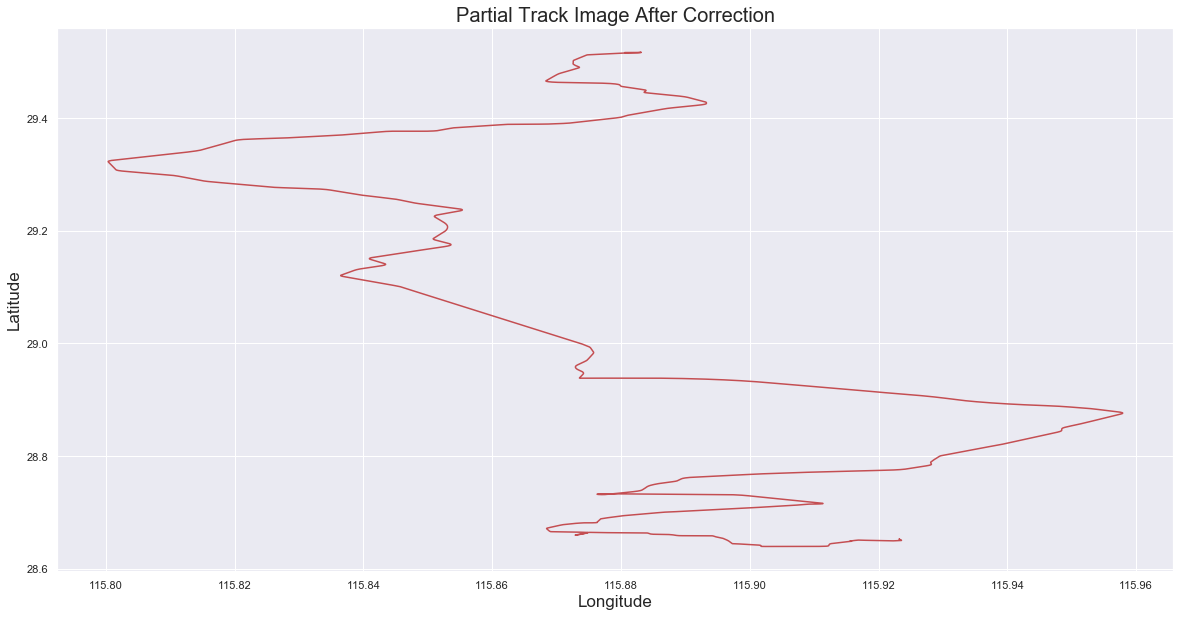

In [77]:
plt.rc('figure', figsize=(20, 10))
seaborn.set()

# plt.scatter(lng_lat[:,0],lng_lat[:,1],c='b')
plt.plot(power_point[:,0],power_point[:,1],c='r')

plt.title("Partial Track Image After Correction", fontsize=20)
plt.xlabel("Longitude",fontsize=17)
plt.ylabel("Latitude",fontsize=17)
plt.savefig("image/distance_image_after/" + filepath.split("/")[-1].split(".")[0] + ".jpg")
plt.show()
plt.close()

data/correct_point/AA00004_0.csv	data/correct_point/AA00004_1.csv	data/correct_point/AA00004_10.csv


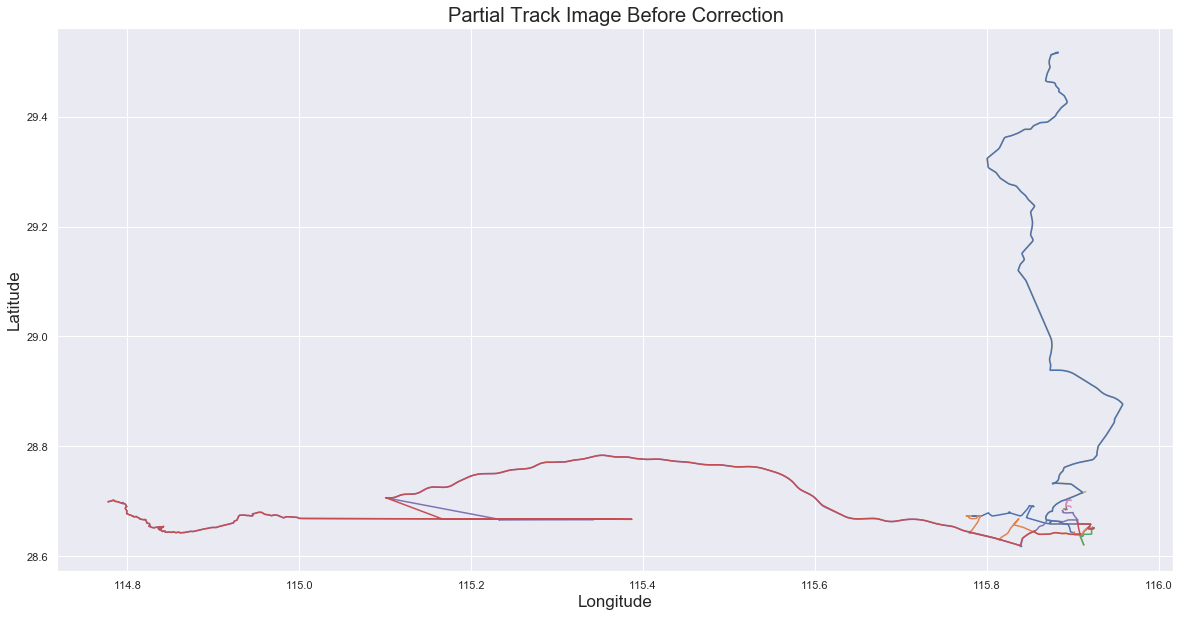

In [90]:
# 获取分段后的所有文件路径
filepath = np.array([])
for root, dirs, files in os.walk('data/correct_point/'):
    filepath = np.concatenate((filepath,np.array([join(root, name) for name in files])))
print("\t".join(filepath[:3]))

plt.rc('figure', figsize=(20, 10))
seaborn.set()
    
for j in range(len(filepath)):
    eeee1 = pd.read_csv(filepath[j])
    eres1 = eeee1[['lng','lat']].values
    
    plt.plot(eres1[:,0],eres1[:,1])

    # plt.savefig("image/distance_image5_before/" + filepath.split("/")[-1].split(".")[0] + ".jpg")

plt.title("Partial Track Image Before Correction", fontsize=20)
plt.xlabel("Longitude",fontsize=17)
plt.ylabel("Latitude",fontsize=17)
plt.show()

#### 对重复项去重，并保留第一个出现的项

In [ ]:
vehicle_tmp2 = vehicle.drop_duplicates(['lng','lat'],inplace=False)
vehicle_tmp2.to_csv("data/" + filepath[j].split("/")[-1].split(".")[0] + ".csv")

### 对数据进行测试

In [ ]:
# vehicle_test = pd.read_csv("../data/attachment_1_100/AA00001.csv")
vehicle_test = pd.read_csv("data/process_file/AA00004_0.csv")

vehicle_test_array = vehicle_test[["location_time","gps_speed"]].values

time = pd.to_datetime(vehicle_test[vehicle_test['gps_speed']!=0]['location_time'])

speed = vehicle_test[vehicle_test['gps_speed']!=0]['gps_speed']
# speed = [i for i in vehicle_test['gps_speed'].tolist() if i !=0]


# Set the global default size of matplotlib figures
plt.rc('figure', figsize=(20, 10))

# Set seaborn aesthetic parameters to defaults
seaborn.set()

plt.plot(time,speed,scalex=True)

plt.title("Gps Speed Distribution", fontsize=20)
plt.xlabel("location_time",fontsize=17)
plt.ylabel("gps_speed",fontsize=17)

# plt.savefig("image/distance_image_after/" + filepath[j].split("/")[-1].split(".")[0] + "_after.jpg")
plt.show()
plt.close()

In [133]:
# 获取分段后的所有文件路径
filepaths = np.array([])
for root, dirs, files in os.walk('data/correct_point/'):
    filepaths = np.concatenate((filepaths,np.array([join(root, name) for name in files])))
print("\t".join(filepaths[:3]))

max_speed = np.array([])
for j in range(len(filepaths)):
    vehicle_test = pd.read_csv(filepaths[j])
    vehicle_speed = vehicle_test[vehicle_test['gps_speed']>50]['gps_speed']
    max_speed = np.concatenate((max_speed,np.array(vehicle_speed)))
    if len(vehicle_speed) > 0:
        print(filepath[j],"\t",len(vehicle_speed),"\t",max(vehicle_speed))

data/correct_point/AA00004_0.csv	data/correct_point/AA00004_1.csv	data/correct_point/AA00004_10.csv
d 	 88 	 68.0
a 	 713 	 80.0
/ 	 4731 	 94.0
r 	 9 	 55.0
r 	 4918 	 91.0
c 	 5057 	 92.0
t 	 65 	 58.0
_ 	 1 	 51.0
p 	 4890 	 97.0


In [ ]:
from collections import Counter
Counter(max_speed)

- - -

### Main:利用经纬度坐标计算行车里程。

In [107]:
all_point_distance = np.array([[0,0,0]])

for j in range(len(filepath)):

    vehicle = pd.read_csv(filepath[j])

    filename = filepath[j].split("/")[-1].split(".")[0]
    
    distance = [(filename,i,haversine(vehicle.iloc[i+1]["lng"],vehicle.iloc[i+1]["lat"],
                                                 vehicle.iloc[i]["lng"],vehicle.iloc[i]["lat"])) for i in range(len(vehicle)-1)]
    
    sum_distance = sum(all_point_distance[:,2].astype('float'))
    print("{}'s mileage：{:.3f}km".format(filename,sum_distance/1000))
    all_point_distance = np.concatenate((all_point_distance,distance))
    

all_point_distance = np.delete(all_point_distance,0,axis=0)

# 每秒最大的距离
# max_distance_mil = max(list(set(vehicle["gps_speed"])))/3.6

sum_distance = sum(all_point_distance[:,2].astype('float'))
print("Total mileage：{:.3f}km".format(sum_distance/1000))

Total mileage：700.993km
